# Insight: Subscription Retention Rate

## Goal

Subscriptions are a great business model. There are so many advantages for businesses in having subscribers compared to single purchase users: revenue by customer is much higher, it is possible to cross-sell to the subscribers, future revenue is easily predictable, there is a significant cost (time/effort/etc.) for the customer in canceling the subscription, etc.
It is no surprise then that so many companies have subscription business models (or try very hard to come up with one!).

The goal of this challenge is to model subscription retention rate.

## Challenge Description

Company XYZ started a subscription model in January, 2015. You get hired as a first data scientist at the end of August and, as a first task, you are asked to help executives understand how the subscription model is doing.

Therefore, you decide to pull data from all the users who subscribed in January and see, for each month, how many of them unsubscribed. In particular, your boss is interested in:
* A model that predicts monthly retention rate for the different subscription price points
* Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?
* How do user country and source affect subscription retention rate? How would you use these findings to improve the company revenue?

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
data = pd.read_csv("subscription.csv")
data.shape

(500000, 7)

In [5]:
data.head()

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,"January, 2015",29,Spain,ads,4,0
1,12474,"January, 2015",49,France,ads,5,0
2,12294,"January, 2015",49,Germany,ads,2,0
3,3878,"January, 2015",49,China,ads,1,0
4,9567,"January, 2015",49,UK,ads,5,0


## Data


* **user_id**: the id of the user. Unique by user.
* **subscription_signup_date**: when the user signed up for the subscription. It is always Jan, 2015 in this table.
* **subscription_monthly_cost**: how much the user pays each month for the subscription (USD)
* **source**: marketing acquisition channel (SEO/Ads/Friend Referral)
* **billing_cycles**: total billing cycles as of the end of August. The user has been subscribed for 4 months before canceling the subscription. That is, in total she paid 4*29 dollars.
* **is_active**: whether the subscription is still active (1) or not (0). If billing cycles is 8, it means the user has still an active subscription.

In [79]:
set(data["subscription_monthly_cost"])

{29, 49, 99}

In [8]:
set(data["subscription_signup_date"]), set(data["billing_cycles"]), set(data["is_active"])

({'January, 2015'}, {1, 2, 3, 4, 5, 6, 7, 8}, {0, 1})

In [10]:
set(data[data.billing_cycles <= 7]["is_active"])

{0}

In [11]:
set(data[data.billing_cycles == 8]["is_active"])

{1}

In [37]:
set(data["country"]), set(data["source"])

({'China', 'France', 'Germany', 'India', 'Italy', 'Spain', 'UK', 'US'},
 {'ads', 'friend_referral', 'seo'})

## Metrics

[The Data Scientist’s Guide to Subscription Businesses](https://towardsdatascience.com/the-data-scientists-guide-to-subscription-businesses-70b1fc4b4493):

### Key financial metrics

* **Average revenue per user (ARPU)**: The average measure of revenue contribution on a per-user basis.
* **Churn Rate**: The churn rate is simply the average number of subscribers that cancelled their subscription over the number of active subscribers in a fixed time period. Typically the period range are set to 7, 14, and 30 days. 
* **Retention Rate**
* **Net Revenue Retention**: Given a cohort, it is the monthly recurring revenue (MRR) of the cohort presently divided by its MRR a year ago

### Measuring the user base

* **Daily Active Users (DAU)** or **Monthly Active Users (MAU)**: There are arguments that DAU and MAU are vanity metrics in that they provide no real value other than bragging rights.
* **Daily New Users (DNU)** or **Monthly New Users (MNU)**

### Marketing metrics

* **Life Time Value (LTV)**: The LTV is a function of both the subscription’s price and the churn rate. It also includes a discount rate, to discount the future value of the cash obtained from a subscription. 

* **Customer Acquisition Cost (CAC)**: The cost of sales and marketing per newly acquired user. We can calculate the CAC on a per marketing channel basis in order to quantify the efficiency of the channel.



### 1. APRU

The average revenue per user (ARPU) is simply the average measure of revenue contribution on a per-user basis.

In [19]:
ARPU = []
for month in range(1, 9):
    subdf = data[data.billing_cycles >= month]
    revenue, count = subdf["subscription_monthly_cost"].sum(), len(subdf)
    ARPU.append(float(revenue)/count)

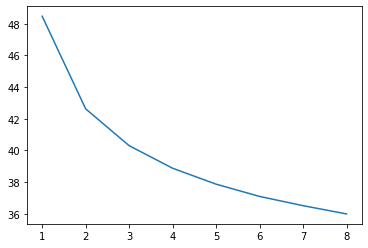

In [20]:
plt.plot(range(1, 9), ARPU)
plt.show()

### 2. Churn rate and retention rate

A subscriber churns when the subscriber terminates her relationship with the business. The churn rate is simply the average number of subscribers that cancelled their subscription over the number of active subscribers in a fixed time period. Typically the period range are set to 7, 14, and 30 days. 

In [124]:
churn_rate, retention_rate = [], [100]
exisitng_users = len(data)
for month in range(2, 9):
    sub_before, sub_after = len(data[data.billing_cycles >= month-1]), len(data[data.billing_cycles >= month])
    churn = sub_before - sub_after
    churn_rate.append(float(churn)*100/sub_before)
    retention_rate.append(float(sub_after)*100/exisitng_users)

# print (churn_rate)

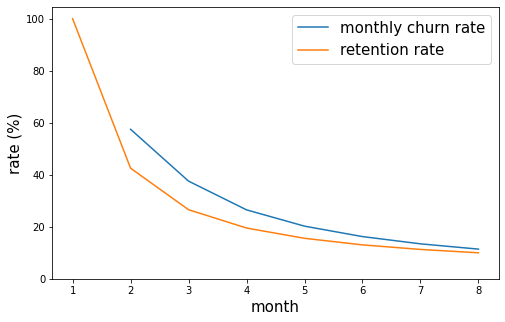

In [38]:
plt.figure(figsize=(8,5))
plt.plot(range(2, 9), churn_rate, label="monthly churn rate")
plt.plot(range(1, 9), retention_rate, label="retention rate")
plt.legend(fontsize=15)
plt.xlabel("month", fontsize=15)
plt.ylabel("rate (%)", fontsize=15)
plt.ylim(0,)
plt.show()

### 3. Models of monthly retention rate

Fit a model to describe how retention rate varies by time. We found **log fit** gives the best result.

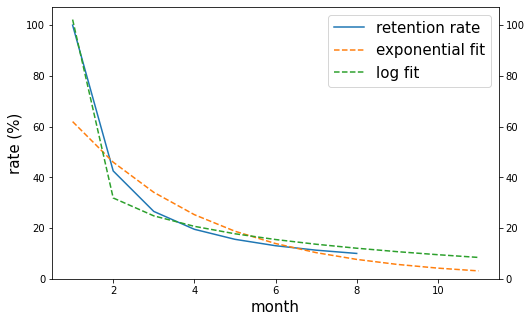

In [126]:
log_fit = np.polyfit(np.log([0.001]+list(range(1, 8))), retention_rate, 1)
B, A = log_fit[0], log_fit[1]
log_pred = [A + B*np.log(x) for x in [0.001]+list(range(1, 11))]

exp_fit = np.polyfit([0.001]+list(range(1, 8)), np.log(retention_rate), 1)
B, A = exp_fit[0], exp_fit[1]
exp_pred = [np.exp(A + B*x) for x in [0.001]+list(range(1, 11))]


plt.figure(figsize=(8,5))
plt.plot(range(1, 9), retention_rate, label="retention rate")
plt.plot(range(1, 12), exp_pred, label="exponential fit", linestyle='--')
plt.plot(range(1, 12), log_pred, label="log fit", linestyle='--')
plt.legend(fontsize=15)
plt.xlabel("month", fontsize=15)
plt.ylabel("rate (%)", fontsize=15)
plt.ylim(0,)
plt.show()

From the above fitting results, after 12 months, overall there are still 10$\%$ customers.

## Q: A model that predicts monthly retention rate for the different subscription price points

Overall speaking, for price > $ \$ 29$, most customers chrun after first month. For example, 61 $ \%$ monthly cost = $ \$49 $ users churn after first month, and 78 $\% $ churn after second month. However, for $ \$29 $, there are only 40 $\%$ churn after first month, and still 24$\%$ retention after 8 months.

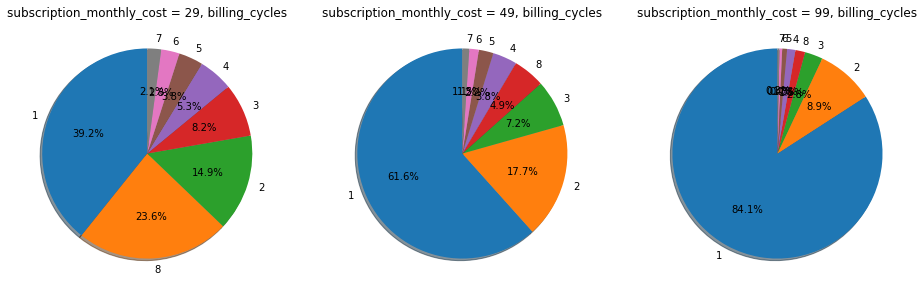

In [101]:
def plot_pieChart(data, attribute="billing_cycles"):
    
    df1 = data.query("subscription_monthly_cost==29")[attribute].value_counts()/len(data.query("subscription_monthly_cost==29"))
    df2 = data.query("subscription_monthly_cost==49")[attribute].value_counts()/len(data.query("subscription_monthly_cost==49"))
    df3 = data.query("subscription_monthly_cost==99")[attribute].value_counts()/len(data.query("subscription_monthly_cost==99"))

    fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
    ax1.pie(df1.values, labels=[x for x in list(df1.index)], autopct='%1.1f%%', shadow=True, startangle=90, normalize=False )
    ax1.set_title("subscription_monthly_cost = 29, "+attribute)
    ax2.pie(df2.values, labels=[x for x in list(df2.index)], autopct='%1.1f%%', shadow=True, startangle=90, normalize=False )
    ax2.set_title("subscription_monthly_cost = 49, "+attribute)
    ax3.pie(df3.values, labels=[x for x in list(df3.index)], autopct='%1.1f%%', shadow=True, startangle=90, normalize=False )
    ax3.set_title("subscription_monthly_cost = 99, "+attribute)

    plt.show()
    
plot_pieChart(data, attribute="billing_cycles")

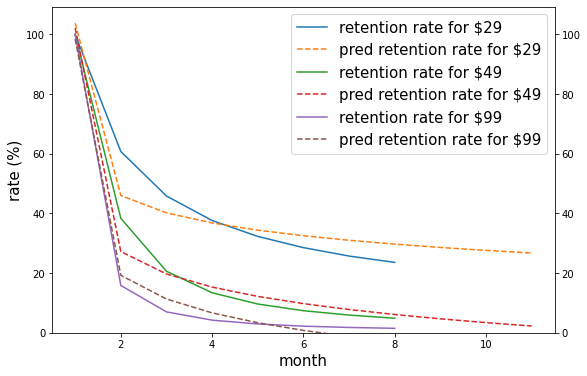

In [100]:
retention_rate = {29: [100], 49:[100], 99:[100]}
exisitng_users = {29: len(data[data.subscription_monthly_cost == 29]), 
                  49: len(data[data.subscription_monthly_cost == 49]), 
                  99: len(data[data.subscription_monthly_cost == 99])}

for month in range(2, 9):
    for price in [29, 49, 99]:
        sub_df = len(data[(data.billing_cycles >= month) & (data.subscription_monthly_cost == price)])
        retention_rate[price].append(float(sub_df)*100/exisitng_users[price])

plt.figure(figsize=(9,6))
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

for price in [29, 49, 99]:
    plt.plot(range(1, 9), retention_rate[price], label="retention rate for $" + str(price))
    
    log_fit = np.polyfit(np.log([0.001]+list(range(1, 8))), retention_rate[price], 1)
    B, A = log_fit[0], log_fit[1]
    
    log_pred = [A + B*np.log(x) for x in [0.001]+list(range(1, 11))]
    plt.plot(range(1, 12), log_pred, label="pred retention rate for $" + str(price), linestyle='--')


plt.legend(fontsize=15)
plt.xlabel("month", fontsize=15)
plt.ylabel("rate (%)", fontsize=15)
plt.ylim(0,)
plt.show()

## Q: Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?

From our model, almost all customers for monthly cost > $\$ 29$ churn after 12 months. However, for $\$29$, there are still about $30\%$ customers.

## Q: How do user country and source affect subscription retention rate? How would you use these findings to improve the company revenue?

### 1. Country

In [102]:
set(data["country"])

{'China', 'France', 'Germany', 'India', 'Italy', 'Spain', 'UK', 'US'}

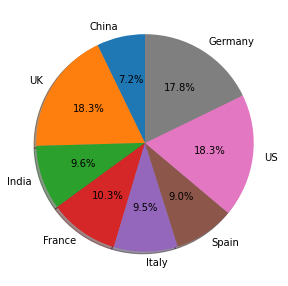

In [115]:
countries = set(data["country"])
num_users = [len(data[data.country == country])/len(data) for country in countries]
fig1, ax = plt.subplots(1, 1, figsize=(16,5))
ax.pie(num_users, labels=countries, autopct='%1.1f%%', shadow=True, startangle=90, normalize=False )
plt.show()

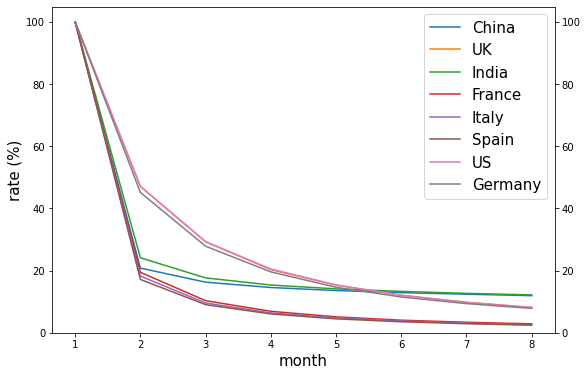

In [119]:
retention_rate = {country: [100] for country in countries}
exisitng_users = {country: len(data[data.country == country]) for country in countries}

for month in range(2, 9):
    for country in countries:
        sub_df = len(data[(data.billing_cycles >= month) & (data.country == country)])
        retention_rate[country].append(float(sub_df)*100/exisitng_users[country])

plt.figure(figsize=(9,6))
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

for country in countries:
    plt.plot(range(1, 9), retention_rate[country], label=country)
    

plt.legend(fontsize=15)
plt.xlabel("month", fontsize=15)
plt.ylabel("rate (%)", fontsize=15)
plt.ylim(0,)
plt.show()


Customers from India and China have higher loyalty over 8 months. Before 5 months, customers from US and Gremany have higher retention intent. 

### 2. Source

In [103]:
set(data["source"])

{'ads', 'friend_referral', 'seo'}

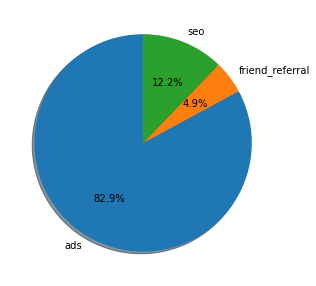

In [121]:
sources= set(data["source"])
num_users = [len(data[data.source == source])/len(data) for source in sources]
fig1, ax = plt.subplots(1, 1, figsize=(16,5))
ax.pie(num_users, labels=sources, autopct='%1.1f%%', shadow=True, startangle=90, normalize=False )
plt.show()

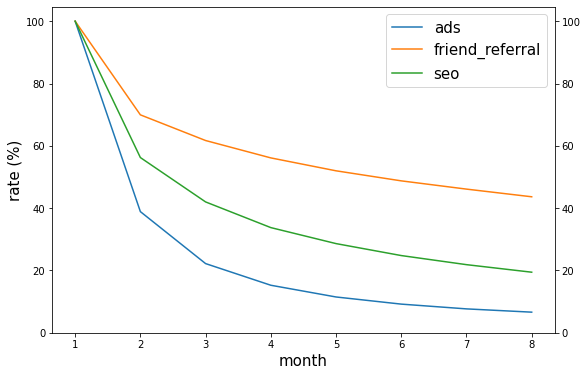

In [122]:
retention_rate = {source: [100] for source in sources}
exisitng_users = {source: len(data[data.source == source]) for source in sources}

for month in range(2, 9):
    for source in sources:
        sub_df = len(data[(data.billing_cycles >= month) & (data.source == source)])
        retention_rate[source].append(float(sub_df)*100/exisitng_users[source])

plt.figure(figsize=(9,6))
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

for source in sources:
    plt.plot(range(1, 9), retention_rate[source], label=source)
    
plt.legend(fontsize=15)
plt.xlabel("month", fontsize=15)
plt.ylabel("rate (%)", fontsize=15)
plt.ylim(0,)
plt.show()


Above shows the subscription from friend referral has higher loyalty, even 40% retention after 8 months. Se

## Supplement: Where does Data Science fit?

Data science itself plays a role in directly forecasting and optimizing these metrics through improving marketing and helping to convert customers to the subscription product [The Data Scientist’s Guide to Subscription Businesses](https://towardsdatascience.com/the-data-scientists-guide-to-subscription-businesses-70b1fc4b4493):
.

### Direct metric forecasts

Forecasts of the ARR and ARPU are used to know if the business is performing well. Use the SARIMA (seasonal ARIMA) or Facebook’s Prophet.

### Churn prediction

At the **macro** level, we forecast churn over predefined cohorts of subscribers, like in the retention curve chart shown above. These are aggregated groups of subscribers, for instance, over a geographic region such as North America. Its purpose is to track churn rates of the business over time as product rollouts continue, to see if the product is providing more value to subscribers over time.

The **micro**-level is where things get interesting. Here, machine learning models are developed to detect subscribers who are on the verge of churning. These models factor in various features about the subscriber to make a prediction of the subscriber churning. Features used come primarily from two sources: **demographic** and **behavioral** information. 

### Lead scoring

The goal of lead scoring is to find current free users who are likely to subscribe. Users i.e., leads are then ranked from the most likely to convert to the lowest. 